In [1]:
!pip install scanpy scikit-misc --quiet

In [2]:
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
print('Scanpy version:', sc.__version__)

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

Scanpy version: 1.9.6


/tmp/ipykernel_2201/1644390834.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
# !pip install scperturb --upgrade
# from scperturb import *

In [4]:
import sys
sys.path.append("..")
%reload_ext autoreload
%autoreload 2
from src.scperturb import *

# Prepare the data

In [5]:
# !wget https://zenodo.org/record/7041849/files/DatlingerBock2021.h5ad
file = '/scratch/peidli/scPerturb/DatlingerBock2021.h5ad'
adata = sc.read_h5ad(file)
adata

AnnData object with n_obs × n_vars = 39194 × 25904
    obs: 'sample', 'cell_line', 'perturbation', 'perturbation_2', 'tissue_type', 'cancer', 'celltype', 'disease', 'organism', 'perturbation_type', 'perturbation_type_2', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [6]:
if 'processed' in adata.uns.keys():
    print('The dataset is already processed. Skipping processing...')
else:
    adata.layers['counts'] = adata.X.copy()

    # basic qc and pp
    sc.pp.filter_cells(adata, min_counts=1000)
    sc.pp.normalize_per_cell(adata)
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.log1p(adata)

    # high class imbalance
    adata = equal_subsampling(adata, 'perturbation', N_min=200)
    sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

    # select HVGs
    n_var_max = 2000  # max total features to select
    sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
    sc.pp.pca(adata, use_highly_variable=True)
    sc.pp.neighbors(adata)

    adata.uns['processed'] = True

# E-distance

In [7]:
# Compute E-distances
estats = edist(adata, obs_key='perturbation', obsm_key='X_pca', dist='sqeuclidean')

100%|██████████| 496/496 [00:00<00:00, 640.68it/s]


In [8]:
# square matrix, all pairs of perturbations get an e-distance
estats.head()

perturbation,control,LAT_2,LCK_2,JUND_2,ZAP70_2,FOS_2,EGR3_2,EGR4_1,PTPN11_2,LAT_1,...,NFAT5_2,EGR2_2,DOK2_2,FOS_1,LCK_1,PTPN6_2,NR4A1_1,ZAP70_1,RUNX2_2,JUN_2
perturbation,,,,,,,,,,,,,,,,,,,,,
control,0.000000,1.857351,1.682874,0.398605,2.297907,0.264955,0.154562,-0.051668,0.922466,2.454915,...,0.128218,0.227056,0.258738,1.241716,1.672088,0.758530,0.705038,2.033668,0.667272,1.228471
LAT_2,1.857351,0.000000,0.088935,0.408286,0.025676,0.845931,0.810088,1.826895,0.774160,0.306862,...,1.213291,0.667541,0.889225,0.452578,0.338636,1.377520,1.317639,0.690906,0.384068,0.250420
LCK_2,1.682874,0.088935,0.000000,0.386584,0.163634,0.589854,0.691470,1.719065,0.293137,0.112875,...,1.344522,0.750959,0.814475,0.083409,0.060777,0.742161,0.610178,0.129742,0.317346,0.023208
JUND_2,0.398605,0.408286,0.386584,0.000000,0.587741,0.092399,-0.029666,0.438602,0.369950,0.730199,...,0.128783,0.073474,0.138753,0.284401,0.471584,0.616324,0.493029,0.748093,-0.034501,0.190475
ZAP70_2,2.297907,0.025676,0.163634,0.587741,0.000000,0.990963,1.029652,2.219072,0.905296,0.170650,...,1.666026,0.959810,1.124947,0.430837,0.331575,1.497955,1.378983,0.430740,0.473389,0.217957


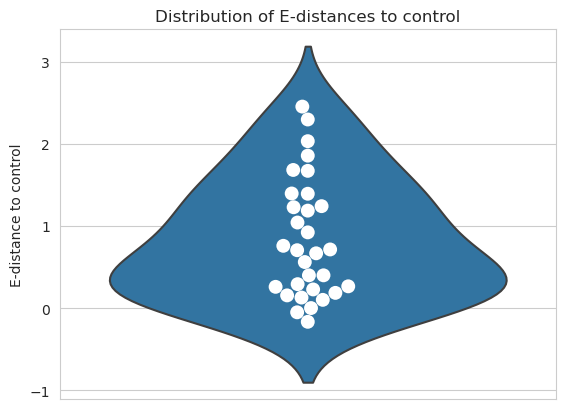

In [9]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=estats.loc['control'], inner=None)
    sns.swarmplot(data=estats.loc['control'], size=10, color='white')
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()

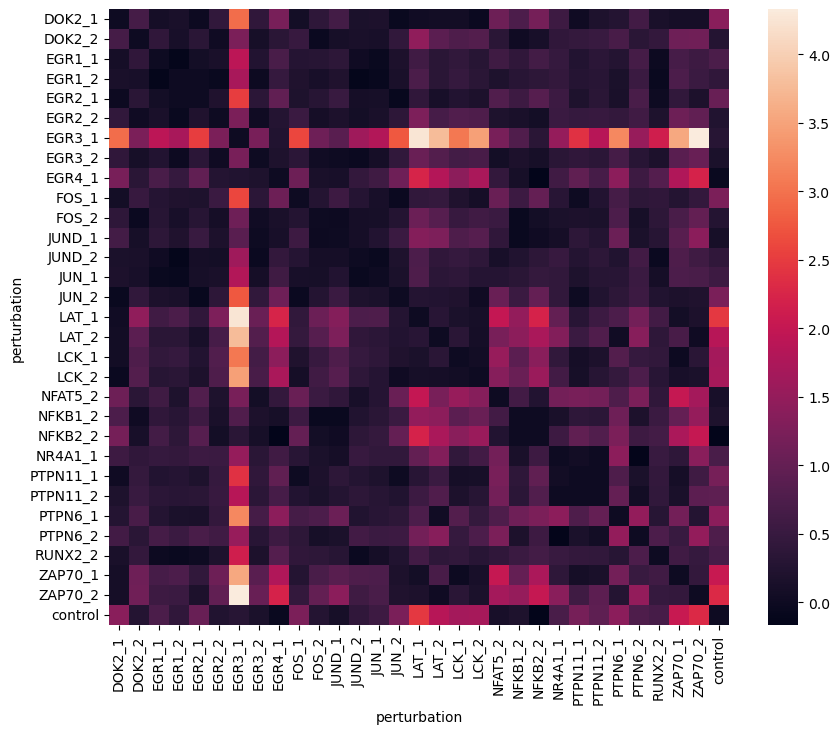

In [10]:
fig, ax = pl.subplots(1,1, figsize=[10,8])
order = estats.sort_index().index
sns.heatmap(estats.loc[order, order])
pl.show()

# E-testing

In [11]:
# e-testing (can be slow)
df = etest(adata, obs_key='perturbation', obsm_key='X_pca', dist='sqeuclidean', control='control', alpha=0.05, runs=1000, n_jobs=-1)

100%|██████████| 1000/1000 [00:07<00:00, 126.29it/s]
/opt/conda/lib/python3.10/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [12]:
df.head()

,edist,pvalue,significant,pvalue_adj,significant_adj
DOK2_1,1.393024,0.001,True,0.030539,True
DOK2_2,0.258738,0.017,True,0.157567,False
EGR1_1,0.714233,0.001,True,0.030539,True
EGR1_2,0.399021,0.002,True,0.030539,True
EGR2_1,1.042278,0.001,True,0.030539,True


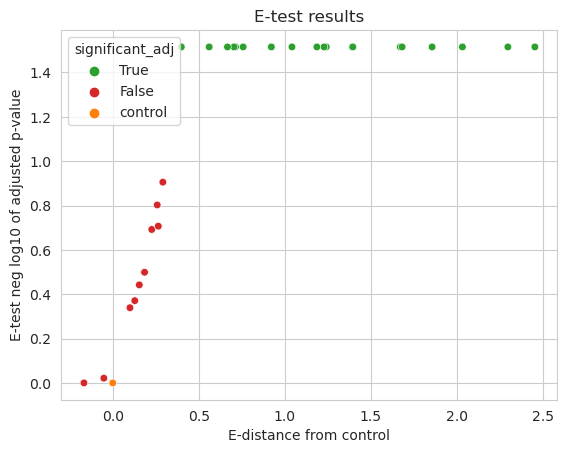

In [13]:
df.loc[df.index=='control', 'significant_adj'] = 'control'
df['neglog10_pvalue_adj'] = -np.log10(df['pvalue_adj'])
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=df, y='neglog10_pvalue_adj', x='edist', hue='significant_adj', palette={True: 'tab:green', False: 'tab:red', 'control': 'tab:orange'}, s=30)
pl.title('E-test results')
pl.xlabel('E-distance from control')
pl.ylabel('E-test neg log10 of adjusted p-value')
pl.show()

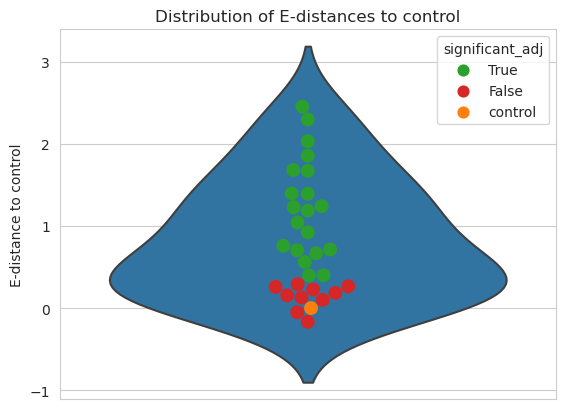

In [14]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=df, y='edist', inner=None)
    sns.swarmplot(data=df, x=[0]*len(df), y='edist', size=10, hue='significant_adj', dodge=False, palette={True: 'tab:green', False: 'tab:red', 'control': 'tab:orange'})
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()